In [6]:
from skimage.draw import circle_perimeter_aa
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
import utils
from torch.utils.data import DataLoader, TensorDataset

In [8]:
from prepare_data import get_data


data = get_data(noise_level=0.1, img_size=100, num_samples=30000)

Using parameters: noise_level=0.1, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
Data saved to ../data/noise_0.1_size_100_samples_30000.pkl


In [4]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2)

# Access images and parameters
train_images, train_params = zip(*train_data)
test_images, test_params = zip(*test_data)

X_train = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)
Y_train = torch.tensor(train_params, dtype=torch.float32)

X_test = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1)
Y_test = torch.tensor(test_params, dtype=torch.float32)

train_data = TensorDataset(X_train, Y_train)
test_data = TensorDataset(X_test, Y_test)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/tmp/ipykernel_4124248/40349523.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X_train = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)


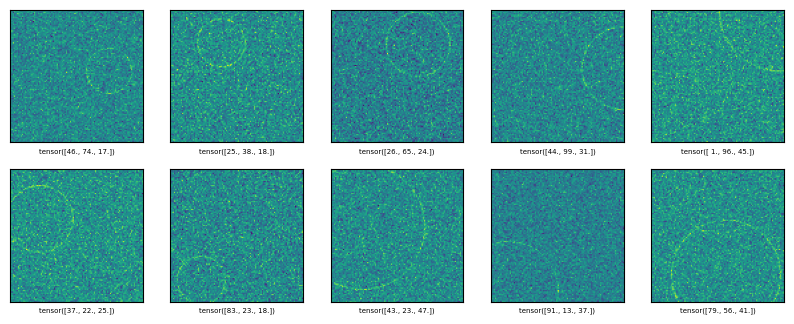

In [7]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].squeeze())
    plt.xlabel(Y_train[i], fontsize = 5)